In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tqdm

duplicates = 2

In [2]:
def num2str(num):
    card_colors = ['r', 'y', 'g', 'b']
    card_types = ['00','w0', 'w4']
    for dup in range(duplicates):
        card_types += [f'{i}{dup}' for i in ['1','2','3','4','5','6','7','8','9','d','r','s']]
        
    color = card_colors[num%4]
    card_type = card_types[num//4]
    
    return f'{color}{card_type}'

str2num = {num2str(i):i for i in range(4*(3+duplicates*12))}

In [3]:
def new_deck():
    deck = np.arange(4*(3+duplicates*12)) # 4 colors, 3 solo cards, 12 duplicates
    np.random.shuffle(deck)
    deck = [num2str(i) for i in deck]
    return list(deck)

In [4]:
def draw_card(deck):
    if len(deck) < 1:
        raise ValueError('Deck is empty')
    return deck.pop()

In [5]:
def playable_cards(hand, top_card='r00'):
    playable = []
    
    for card in hand:
        if card[1] != 'w': # don't consider wild cards yet
            if card[0] == top_card[0] or card[1:] == top_card[1:]:
                playable.append(card)
        else:
            if card[1:] == 'w0': # non-drawing wild card
                playable.append(card)
    
    if len(playable) == 0:
        for card in hand:
            if card[1:] == 'w4': # drawing wild card
                playable.append(card)
    
    return playable

In [6]:
num_cards = 4*(3+duplicates*12)

In [7]:
def remove_predicted_card(predicteds, card):
    for i in range(len(predicteds)):
        sum_i = np.sum(predicteds[i,:])
        predicteds[i,str2num[card]] = 0
        sum_i_new = np.sum(predicteds[i,:])
        predicteds[i,:] *= sum_i/sum_i_new # renormalize
    return predicteds

def draw_card_predict(predicteds, player):
    predicteds[player,:] += predicteds[0,:] / predicteds[0,:].sum() # update predicted card counts
    predicteds[0,:] -= predicteds[0,:] / predicteds[0,:].sum() # remove cards from deck count
    return predicteds

def sync_player_counts(predicteds, hands, deck):
    predicteds[0,:] = predicteds[0,:] / predicteds[0,:].sum() * len(deck)
    
    for player in range(1, len(hands)):
        predicteds[player,:] = predicteds[player,:] / predicteds[player,:].sum() * len(hands[player])
    
    return predicteds

def player_draws_prediction(predicteds, player, top_card):    
    impossible_cards = playable_cards([num2str(i) for i in range(num_cards)], top_card)
    impossible_cards += ['rw4', 'yw4', 'gw4', 'bw4'] # couldn't have a wild card either
    for card in impossible_cards:
        predicteds[player,str2num[card]] = 0
    return predicteds

def renormalize(predicteds):
    for i in range(predicteds.shape[1]):
        if np.sum(predicteds[:,i]) > 0:
            predicteds[:,i] = predicteds[:,i] / np.sum(predicteds[:,i]) # only one of each card can be in the deck
        else:
            predicteds[:,i] = 0
    return predicteds

In [14]:
def complex_logic(hand, top_card, predicteds, direction):
    playable = playable_cards(hand, top_card)
    
    predicted_hands = []
    hand_sizes = []
    for player in range(1, len(predicteds)):
        predicted_hands.append([])
        hand_sizes.append(np.sum(predicteds[player,:]))
        # determine most likely cards in other players' hands
        p = 0
        predicteds_copy = predicteds.copy()
        while p < 0.3:
            predicted_hands[player-1].append(num2str(np.argmax(predicteds_copy[player,:])))
            p += np.max(predicteds_copy[player,:])
            predicteds_copy[player,np.argmax(predicteds_copy[player,:])] = 0
    
    # determine the best card to play
    
    if hand_sizes[direction] <= 3: 
        # if the neighbor has few cards, maximize the chance of them drawing
        for card in playable:
            if card[1] in ['d','r','s', 'w']:
                return card
    else:
        if min(hand_sizes) <= 3:
            target_player = np.argmin(hand_sizes)
            # if the other player has few cards, play a card that they are least likely to match
            lowest_match = 9999
            for card in playable:
                if len(playable_cards(predicted_hands[target_player], card)) < lowest_match:
                    lowest_match = len(playable_cards(predicted_hands[target_player], card))
                    best_card = card
            return best_card
    
    # play card with most similar colors
    colors = [card[0] for card in playable]
    color_counts = {color: colors.count(color) for color in colors}
    best_color = max(color_counts, key=color_counts.get)
    best_card = [card for card in playable if card[0] == best_color][0]
    return best_card

In [15]:
def play_game(verbose=False):
    players=4

    deck = new_deck()

    predicteds = np.zeros((players, num_cards), dtype=float)
    predicteds[0, :] = np.ones(num_cards) # zero index used for deck, player 0 knows own cards exactly

    hands = [[] for _ in range(players)] # initialize hands
    for i in range(7): # draw 7 cards for each player
        for j in range(players):
            hands[j].append(draw_card(deck))

    for i in range(1, players): # draw 7 cards for each player
        for _ in range(7):
            predicteds = draw_card_predict(predicteds, i)

    for card in hands[0]: # remove known cards from predictions
        predicteds = remove_predicted_card(predicteds, card)

    discard_pile = [draw_card(deck)] # draw first card
    predicteds = remove_predicted_card(predicteds, discard_pile[-1])

    if verbose:
        print('First Card:', (discard_pile[-1]))
        
    player = random.randint(0, players-1) # choose a random player to start;
    direction = 1; turn = 0 # initialize game variables
    hand_sizes = [[len(h) for h in hands]] # keep track of hand sizes

    while True:
        if verbose:
            print(f'Turn {turn}: Player {player} : {hands[player]}')
        
        # player turn
        playable = playable_cards(hands[player], discard_pile[-1])
        
        if len(playable) == 0: # no playable cards, draw
            hands[player].append(draw_card(deck))
            playable = playable_cards(hands[player], discard_pile[-1])
            if player != 0:
                predicteds = draw_card_predict(predicteds, player)
                predicteds = player_draws_prediction(predicteds, player, discard_pile[-1])
                predicteds = renormalize(predicteds)
            if verbose:
                print('Player', player, 'draws a card', hands[player][-1])
            if len(playable) == 0: # still no playable cards, pass
                if verbose:
                    print('Player', player, 'passes')
                player = (player + direction) % players
                continue
        
        if player == 0: # human player
            card = complex_logic(hands[player], discard_pile[-1], predicteds, direction)
        else:
            card = random.choice(playable)
        hands[player].remove(card)
        discard_pile.append(card)
        predicteds = remove_predicted_card(predicteds, card) # card location is known, remove from predictions
        
            
        if verbose:
            print('Player', player, 'plays', card)
        if len(hands[player]) == 0: # player wins
            if verbose:
                print('Player', player, 'wins!')
            hand_sizes.append([len(h) for h in hands])
            break
            
        # handle special cards
        if card[1] == 's': # skip
            player = (player + direction) % players
        elif card[1] == 'r': # reverse
            direction *= -1
        elif card[1] == 'd': # draw 2
            hands[(player + direction) % players] += [draw_card(deck) for _ in range(2)]
            if (player + direction) % players != 0:
                for _ in range(2):
                    predicteds = draw_card_predict(predicteds, (player + direction) % players)
            else:
                for i in range(1,3):
                    predicteds = remove_predicted_card(predicteds, hands[0][-1*i])
                    
            if verbose:
                print(f'Player{(player + direction) % players} drew 2 cards {hands[(player + direction) % players][-2:]}')
            player = (player + direction) % players # skip the next player
        elif card[1] == 'w': # wild
            hand_colors = [card[0] for card in hands[player]]
            color = random.choice(hand_colors)
            card = color + card[1:]
            discard_pile[-1] = card # change the color
            if verbose:
                print('Player', player, 'changed the color to', color)
            if card[1:] == 'w4': # wild draw 4
                hands[(player + direction) % players] += [draw_card(deck) for _ in range(4)]
                if (player + direction) % players != 0:
                    for _ in range(4):
                        predicteds = draw_card_predict(predicteds, (player + direction) % players)
                else:
                    for i in range(1,4):
                        predicteds = remove_predicted_card(predicteds, hands[0][-1*i])
                if verbose:
                    print(f'Player{(player + direction) % players} drew 4 cards {hands[(player + direction) % players][-4:]}')
                player = (player + direction) % players
            
            
        hand_sizes.append([len(h) for h in hands])
        predicteds = sync_player_counts(predicteds, hands, deck)
        
        player = (player + direction) % players
        turn += 1
        
        if turn > 200:
            if verbose:
                print('Game took too long')
            break
        
    return hand_sizes

In [16]:
hand_sizes = []
for _ in tqdm.tqdm(range(10000)):
    try:
        hand_sizes.append(play_game(verbose=False))
    except ValueError:
        pass

  0%|          | 6/10000 [00:00<02:53, 57.70it/s]C:\Users\Adam\AppData\Local\Temp\ipykernel_31884\267352511.py:6: RuntimeWarning: invalid value encountered in scalar divide
  predicteds[i,:] *= sum_i/sum_i_new # renormalize
  0%|          | 24/10000 [00:00<03:42, 44.75it/s]C:\Users\Adam\AppData\Local\Temp\ipykernel_31884\267352511.py:15: RuntimeWarning: invalid value encountered in divide
  predicteds[0,:] = predicteds[0,:] / predicteds[0,:].sum() * len(deck)
100%|██████████| 10000/10000 [03:24<00:00, 48.91it/s]


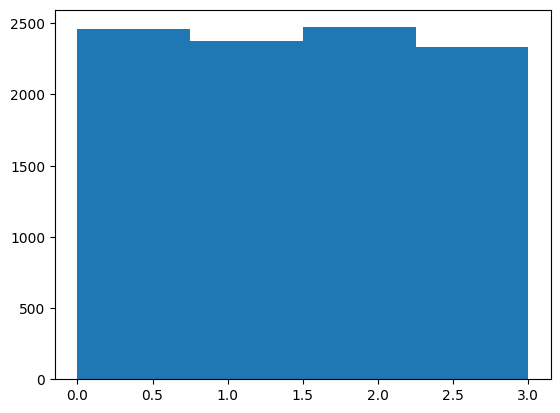

In [17]:
winners = []
for i in range(len(hand_sizes)):
    winner = np.argmin(hand_sizes[i][-1])
    winners.append(winner)

plt.hist(winners, bins=4)
plt.show();